In [33]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import random
import matplotlib.pyplot as plt
from Utils import preprocess, string_to_tensor, plot_graphs
criterion = nn.CrossEntropyLoss()

# Importing data

### Selecting Language

In [34]:
language = 'tam'
start_token = '<'
end_token = '>'
pad_token = ' '
unk_token = '~'

In [35]:
path = 'aksharantar_sampled/' + language

train_df = pd.read_csv(path+'/'+language+'_train.csv', header=None)
test_df = pd.read_csv(path+'/'+language+'_test.csv', header=None)
val_df = pd.read_csv(path+'/'+language+'_valid.csv', header=None)

train_source, train_target = train_df[0].tolist(), train_df[1].tolist()
test_source, test_target = test_df[0].tolist(), test_df[1].tolist()
val_source, val_target = val_df[0].tolist(), val_df[1].tolist()

### Printing Sample

In [36]:
num_sample = 5
for i in range(num_sample):
    print(f'{train_source[i]}  -->  {train_target[i]}')

thottacharya  -->  தொட்டாச்சார்ய
menmaithaan  -->  மென்மைதான்
avarantri  -->  அவரன்றி
mudiyarathu  -->  முடியறது
aadaiyanigalaal  -->  ஆடையணிகளால்


In [37]:
english_chars = list(set(''.join(train_source) + start_token + end_token + pad_token + unk_token))
target_chars = list(set(''.join(train_target) + start_token + end_token + pad_token + unk_token))

english_dict_count = len(english_chars)
target_dict_count = len(target_chars)

print("Number of Charecters : ", target_dict_count)

print("Target Charecters: ")
for i, c in enumerate(target_chars):
    print(i, c, end='\t')
    if i % 5 == 0:
        print()
print()

Number of Charecters :  50
Target Charecters: 
0 ஜ	
1 ோ	2 ட	3 ம	4 ன	5 ு	
6 அ	7 ை	8 வ	9 ஞ	10 ஈ	
11 ண	12 ஓ	13 >	14 ச	15 ி	
16  	17 ல	18 ஃ	19 ஊ	20 ழ	
21 ஷ	22 த	23 ஒ	24 ஆ	25 ௌ	
26 <	27 ங	28 ~	29 ்	30 ஏ	
31 ீ	32 எ	33 இ	34 ஹ	35 ய	
36 ள	37 ூ	38 ே	39 ற	40 ஸ	
41 ந	42 உ	43 ொ	44 ஐ	45 ா	
46 ர	47 ப	48 க	49 ெ	


In [38]:
en_i2l, en_l2i = {}, {}
tr_i2l, tr_l2i = {}, {}

for i, x in enumerate(english_chars):
    en_l2i[x] = i
    en_i2l[i] = x

for i, x in enumerate(target_chars):
    tr_l2i[x] = i
    tr_i2l[i] = x

### Preprocessing test and validation data

In [39]:
val_source_tensor = string_to_tensor(preprocess(val_source, start_token, end_token, pad_token), en_l2i, unk_token).transpose(0,1).requires_grad_(False)
val_target_tensor = string_to_tensor(preprocess(val_target, start_token, end_token, pad_token), tr_l2i, unk_token).transpose(0,1).requires_grad_(False)

test_source_tensor = string_to_tensor(preprocess(test_source, start_token, end_token, pad_token), en_l2i, unk_token).transpose(0,1).requires_grad_(False)
test_target_tensor = string_to_tensor(preprocess(test_target, start_token, end_token, pad_token), tr_l2i, unk_token).transpose(0,1).requires_grad_(False)

# Encoder

In [40]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, num_layers = 1, p = 0, bi_dir = False, rnn_class = nn.GRU):
        """
        Init Parameters:
        input_size : english_dict_count
        embedding_size : size of each embedding vector
        hidden_size : size of hidden state vector
        num_layers : number of recurrent layers of RNN
        p : dropout probability
        rnn_class: type of RNN to be used in the encoder

        Input:
        x : torch.Tensor of shape (seq_length, N)
            where seq_length - len of longest string in the batch
            N - batch size
        
        Outpus:
        outputs: torch.Tensor of shape (seq_len, N, hidden_size * D), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size) if(rnn_class == "LSTM")
        """
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn_class= rnn_class
        self.rnn = rnn_class(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)


    def forward(self, x):
        # x shape: (seq_length, N) where N is batch size

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (seq_length, N, embedding_size)

        if(self.rnn_class.__name__ == "LSTM"):
            outputs, (hidden, cell) = self.rnn(embedding)
            # outputs shape: (seq_length, N, hidden_size)
        else:
            outputs, hidden = self.rnn(embedding)
        
        if(self.rnn_class.__name__ == "LSTM"):
            return outputs, hidden, cell
        else:
            return outputs, hidden


# Decoder

In [41]:
class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers = 1, p = 0, bi_dir = False, rnn_class = nn.GRU):
        """input size = output size = target language charecters
        Init Parameters:
        input_size: target_dict_count
        embedding_size: size of each embedding vector
        hidden_size: size of hidden state vector
        output_size: number of output features in fully connected layer
        num_layers : number of recurrent layers of RNN
        p : dropout probability
        rnn_class: type of RNN to be used in the encoder

        Input:
        x: torch.Tensor of shape (N)
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size)

        Outputs:
        predications: torch.Tensor of shape (N, target_dict_count), where D = 2 if bi_dir = True else 1
        hidden: torch.Tensor of shape (num_layers * D, N, hidden_size)
        
        cell: torch.Tensor of shape (num_layers * D, N, hidden_size) if(rnn_class == "LSTM")
        """
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn_class = rnn_class
        self.rnn = rnn_class(embedding_size, hidden_size, num_layers, dropout=p, bidirectional = bi_dir)

        self.D = 1
        if(bi_dir == True):
            self.D = 2
        self.fc = nn.Linear(hidden_size * self.D, output_size)


    def forward(self, x, hidden, cell = None):
        #cell is set to none, for GRU and RNN

        # x shape: (N) where N is for batch size, we want it to be (1, N), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        # print(x.shape, hidden.shape, cell.shape)
        x = x.unsqueeze(0)

        embedding = self.dropout(self.embedding(x))
        # embedding shape: (1, N, embedding_size)
        
        if(self.rnn_class.__name__ == "LSTM"):
            outputs, (hidden, cell) = self.rnn(embedding, (hidden, cell))
            # outputs shape: (1, N, hidden_size * D)
        else:
            outputs, hidden = self.rnn(embedding, hidden)
            

        predictions = self.fc(outputs)

        # predictions shape: (1, N, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(0)

        if(self.rnn_class.__name__ == "LSTM"):
            return predictions, hidden, cell
        else:
            return predictions, hidden

# Model

In [42]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        encoder_layers = encoder.num_layers
        decoder_layers = decoder.num_layers
        D = decoder.D #we set bidiretion as common in both encoder and decoder, so no need to check for D value seperately
        self.enc_to_dec = nn.Linear(encoder_layers*D, decoder_layers*D)
        self.rnn_class = decoder.rnn_class #we use same rnn in both encoder and decoder

    def forward(self, source, target, teacher_force_ratio=0):
        """source : (source_len, N) - not sure
        teacher_forching_ratio : probability in which original values is favored over predicted values
                                if 0 : predicted values is passed for all chars in target
                                if 1 : true values is passed for all chars in target

        """
        batch_size = source.shape[1] 
        target_len = target.shape[0]
        target_vocab_size = target_dict_count

        # print("source shape ", source.shape)
        # print("target shape ", target.shape)
        # print("N : ", batch_size)
        # print("tar len : ", target_len)

        outputs = torch.zeros(target_len, batch_size, target_vocab_size)
        # print("outputs shape : ", outputs.shape)

        
        if(self.rnn_class.__name__ == "LSTM"):
            _, hidden, cell = self.encoder(source)
        else:
            _, hidden = self.encoder(source)

        N = hidden.shape[1]
        hidden_size= hidden.shape[2]
        # hidden, cell shape: (D*encoder_layers, N, hidden_size)

        hidden = hidden.transpose(0, 2) # hidden shape: (hidden_size, N, D*encoder_layers)
        hidden = hidden.reshape(-1, hidden.shape[2]) # hidden shape: (hidden_size * N, D*encoder_layers)
        hidden = self.enc_to_dec(hidden) # hidden shape: (hidden_size * N, D*decoder_layers)
        hidden = hidden.reshape(hidden_size, N, hidden.shape[1]) # hidden shape: (hidden_size, N, D*decoder_layers)
        hidden = hidden.transpose(0,2) # hidden shape: (D*decoder_layers, N, hidden_size)

        if(self.rnn_class.__name__ == "LSTM"):
            #at all the below steps, cell will have the shape of hidden
            cell = cell.transpose(0,2)
            cell = cell.reshape(-1, cell.shape[2])
            cell = self.enc_to_dec(cell)
            cell = cell.reshape(hidden_size, N, cell.shape[1])
            cell = cell.transpose(0,2)

        # Grab the first input to the Decoder which will be <SOS> token
        x = target[0]
        outputs[:, :, tr_l2i[start_token]] = 1 #setting prob = 1 for starting token 

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start
            if(self.rnn_class.__name__ == "LSTM"):
                output, hidden, cell = self.decoder(x, hidden, cell)
            else:
                output, hidden = self.decoder(x, hidden)

            # Store next output prediction
            outputs[t] = output

            # Get the best word the Decoder predicted (index in the vocabulary)
            best_guess = output.argmax(1)

            # With probability of teacher_force_ratio we take the actual next word
            # otherwise we take the word that the Decoder predicted it to be.
            # Teacher Forcing is used so that the model gets used to seeing
            # similar inputs at training and testing time, if teacher forcing is 1
            # then inputs at test time might be completely different than what the
            # network is used to. This was a long comment.
            x = target[t] if random.random() < teacher_force_ratio else best_guess
        # print("OUTPUTS: ", outputs)
        return outputs


    def calc_accuracy(self, output, target):
        """
        output: torch.Tensor of shape (seq_len, N)
        target: torch.Tensor of shape (seq_len, N)
        """
        # batch_size = 32
        running_acc = 0
        seq_len = output.shape[0]
        N = output.shape[1]
        matched_strings = 0
        with torch.no_grad():
            for j in range(N):
                current_word_matched = True
                for i in range(seq_len):
                    if(target[i][j] in {tr_l2i[pad_token], tr_l2i[start_token], tr_l2i[end_token]}):
                        continue
                    if(output[i][j] != target[i][j]):
                        current_word_matched = False
                        break
                if(current_word_matched == True):
                    matched_strings += 1
        return matched_strings*100 / N 


    def calc_evaluation_metrics(self, soruce_strings, target_strings):
        """

        Returns:
        loss: loss value for the current batch of strings
        accuracy: accuracy value for the current batch of strings
        """
        batch_size = 32
        loss  = 0
        with torch.no_grad():
            no_of_batch = 0
            running_accuracy = 0
            for i in range(0, len(soruce_strings), batch_size):
                inp_data = string_to_tensor(preprocess(soruce_strings[i:i+batch_size], start_token, end_token, pad_token), en_l2i, unk_token).transpose(0,1)
                target = string_to_tensor(preprocess(target_strings[i:i+batch_size], start_token, end_token, pad_token), tr_l2i, unk_token).transpose(0,1)

                output = self(inp_data, target)
                running_accuracy += self.calc_accuracy(output.argmax(2), target)

                output = output.reshape(-1, output.shape[2])
                target = target.reshape(-1)

                loss = criterion(output, target)
                loss += loss.item()
                no_of_batch += 1
        return loss, running_accuracy/no_of_batch
    
 

# Training

In [43]:
# Training hyperparameters
num_epochs = 10
learning_rate = 0.001
batch_size = 32

# Model hyperparameters
load_model = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = english_dict_count
input_size_decoder = target_dict_count
output_size = target_dict_count
embedding_size = 32
encoder_layers = 2
decoder_layers = 2
enc_dropout = 0.5
dec_dropout = 0.5
hidden_size = 64
bi_directional = True
rnn = nn.LSTM

In [44]:
enc = Encoder(english_dict_count, embedding_size, hidden_size, 
              num_layers=encoder_layers, 
              bi_dir=bi_directional,
              p=enc_dropout,
              rnn_class=rnn)
dec = Decoder(target_dict_count, embedding_size, hidden_size, target_dict_count, 
              num_layers=decoder_layers, 
              bi_dir=bi_directional, 
              p = dec_dropout,
              rnn_class=rnn)

mod = Seq2Seq(enc, dec)

optimizer = optim.Adam(mod.parameters(), lr=learning_rate)

In [45]:
def temp_print(output):
    """output shape: target_seq_length * N"""
    res = []
    for j in range(output.shape[1]):
        temp = ""
        for i in range(output.shape[0]):
            temp += tr_i2l[output[i,j].item()]
        
        res.append(temp)
    return res

[Epoch   1/10] 	 Loss: 2.100	 Acc: 0.00 	 Val Loss: 4.219	 Val Acc: 0.00
[Epoch   2/10] 	 Loss: 2.113	 Acc: 0.00 	 Val Loss: 4.342	 Val Acc: 0.00
[Epoch   3/10] 	 Loss: 2.147	 Acc: 0.00 	 Val Loss: 4.226	 Val Acc: 0.00
[Epoch   4/10] 	 Loss: 2.108	 Acc: 0.00 	 Val Loss: 4.043	 Val Acc: 0.00
[Epoch   5/10] 	 Loss: 2.103	 Acc: 0.00 	 Val Loss: 3.964	 Val Acc: 0.00
[Epoch   6/10] 	 Loss: 2.127	 Acc: 0.00 	 Val Loss: 4.046	 Val Acc: 0.00
[Epoch   7/10] 	 Loss: 2.101	 Acc: 0.00 	 Val Loss: 4.114	 Val Acc: 0.00
[Epoch   8/10] 	 Loss: 2.119	 Acc: 0.00 	 Val Loss: 4.076	 Val Acc: 0.00
[Epoch   9/10] 	 Loss: 2.087	 Acc: 0.00 	 Val Loss: 3.998	 Val Acc: 0.00
[Epoch  10/10] 	 Loss: 2.110	 Acc: 0.00 	 Val Loss: 4.066	 Val Acc: 0.00


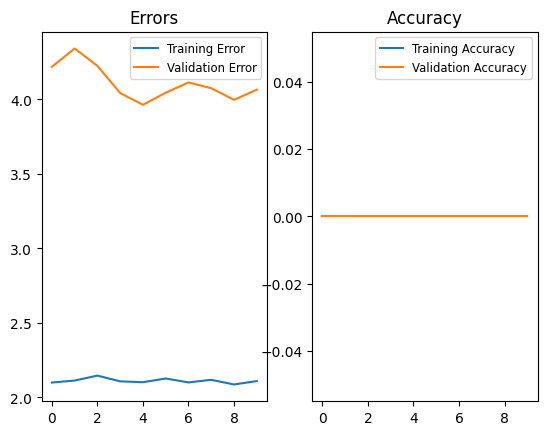

In [52]:
loss_list, acc_list, val_loss_list, val_acc_list = [], [], [], []

init_teacher_forcing_ratio = 0.8
for epoch in range(num_epochs):
    running_loss = 0
    no_of_batch = 0
    running_accuracy = 0

    for i in range(0, len(train_source[:32]), batch_size):
        src_strings = train_source[i: i+batch_size]
        tar_strings = train_target[i: i+batch_size]

        src_strings = preprocess(src_strings, start_token, end_token, pad_token)
        tar_strings = preprocess(tar_strings, start_token, end_token, pad_token)

        #transposing to make the shape as expected
        inp_data = string_to_tensor(src_strings, en_l2i, unk_token).transpose(0,1)
        target = string_to_tensor(tar_strings, tr_l2i, unk_token).transpose(0,1)

        #here teacher forcing ratio will reduces linearly from init_teacher_forcing_ratio to 0 in half the number of epochs
        teacher_forcing_ratio = max(0, init_teacher_forcing_ratio * (1 - (epoch*2/num_epochs)))
        output = mod(inp_data, target, teacher_forcing_ratio)

        running_accuracy += mod.calc_accuracy(output.argmax(2), target)

        # print("train: output : ", output.shape)
        # result = temp_print(output.argmax(2))
        # print("result: ", result)
        # print("target: ", tar_strings)
        
        # print("output: ",result)
        # print("target:", tar_strings)

        # print("op before reshopsed ", output.shape)
        # print("tar before reshape: ", target.shape)

        output = output.reshape(-1, output.shape[2])
        target = target.reshape(-1)

        # print("op: ", output.shape)
        # print("tar: ", target.shape)

        optimizer.zero_grad()
        loss = criterion(output, target)

        # Back prop
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mod.parameters(), max_norm=1)
        optimizer.step()
        running_loss += loss.item()
        no_of_batch += 1        

    # val_output = mod(val_source_tensor, val_target_tensor)
    # val_output = val_output.reshape(-1, val_output.shape[2])
    # val_target_tensor = val_target_tensor.reshape(-1)
    # # print(f"val output : {val_output.shape} \t val_target: {val_target_tensor.shape}")
    # val_loss = criterion(val_output, val_target_tensor)

    val_loss, val_accuracy= mod.calc_evaluation_metrics(val_source[:32], val_target[:32])
    # val_loss = 0

    print(f"[Epoch {epoch+1:3d}/{num_epochs}] \t Loss: {(running_loss/no_of_batch):.3f}\t Acc: {(running_accuracy/no_of_batch):2.2f} \t Val Loss: {val_loss:2.3f}\t Val Acc: {val_accuracy:2.2f}")
    loss_list.append(running_loss/no_of_batch)
    acc_list.append(running_accuracy/no_of_batch)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

fig = plot_graphs(loss_list, val_loss_list, acc_list, val_acc_list)